# Final project
Course : Machine Learning in SoftUni\
Author: Boris Borisov\
Documentation can be found in the README file

## Load libraries

In [649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date,datetime,timedelta
import datetime as dt

# sklearn libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# darts' libraries
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.models import TCNModel
from darts.models import TFTModel

# metrics
from darts.metrics import coefficient_of_variation,dtw_metric,mae,mape,marre,mase,mse
from darts.metrics.metrics import multi_ts_support,multivariate_support, ope,r2_score, rho_risk,rmse,rmsle, smape


## Load pickle file

Start here

In [650]:
df_no_acc_pick = pd.read_pickle('available_data.pkl')
df_no_acc_pick

,planning_group,fis_period,time,euc_mrr,euc_mrr_lead_6months,mrr_change,mrr_change_lead_6months,sr_count_score,ttr_sev12_score,csat_score,...,pr_to_sr_ratio_score,average_tech_health_score,max_boxer,max_osx,max_tot_enrolled,max_horizon,max_hub,max_content,max_win10,max_stickiness
0,company_1,21Q4-P12,0,12167.12785,3615.16435,No-Change,Decrease,1.0,1.0,,...,100.0,50.500000,<NA>,<NA>,<NA>,889,<NA>,<NA>,<NA>,22.73
1,company_1,22Q1-P1,0,12167.12785,3615.16435,No-Change,No-Change,60.0,1.0,,...,100.0,65.250000,<NA>,<NA>,<NA>,889,<NA>,<NA>,<NA>,22.73
2,company_1,22Q1-P2,0,12167.12785,4583.56638,No-Change,No-Change,100.0,,,...,100.0,92.240741,<NA>,<NA>,<NA>,885,<NA>,<NA>,<NA>,22.73
3,company_1,22Q1-P3,0,12167.12785,32045.26810,No-Change,Increase,100.0,,,...,,100.000000,<NA>,<NA>,<NA>,921,<NA>,<NA>,<NA>,22.73
4,company_1,22Q2-P4,0,0.00000,32045.26810,Decrease,No-Change,60.0,,,...,,86.666667,<NA>,<NA>,<NA>,942,<NA>,<NA>,<NA>,22.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,company_20,22Q3-P8,0,24690.90000,24690.90000,No-Change,No-Change,60.0,100.0,,...,60.0,84.814815,9,40,5583,2068,5142,1365,5,61.37
396,company_20,22Q3-P9,0,24690.90000,24690.90000,No-Change,No-Change,60.0,100.0,,...,60.0,79.672840,9,39,5587,2111,5153,1369,6,61.37
397,company_20,22Q4-P10,0,24690.90000,24690.90000,No-Change,No-Change,60.0,100.0,,...,60.0,79.487179,9,32,5474,2099,5072,1331,7,61.37
398,company_20,22Q4-P11,0,24690.90000,24690.90000,No-Change,No-Change,60.0,60.0,,...,60.0,76.410256,9,32,5538,2172,5127,1311,7,61.37


## Start of the preprocessing
How to handle and fill the null values

In [651]:
# df_no_acc_pick
# - remove the column that has more than 50% of its values to be NULL value:
#       -remove columns psat and csat
# - Replace null values in sev1_ratio_score and pr_to_sr_ratio
#       -For these columns, we have NA values because the denominator (SRs created/open) is zero because
#        each planning group has its range for sr_score.
#        Intuitively we would give NA values to be equal to 1 but we decided to give the sr_score
#        because it is designed to assign the correct scores to 0 SR.
# - Replace null values in ttr_sev12_score:
#       -if we have ttr_sev12_score = 0: ttr_sev12_score= sr_count_score of the respective row else: ttr_sev12_score = 100
# - How to handle null values for the max_stickiness column
#       - The companies that have more than 50% of the time values that are NA are removed, 
#          we assume that these PGs are noninformative.
#         The seven companies are removed , which corresponds to 116 dropped rows in the dataframe.
# - how to transform data for columns that calculate values from day to months
#       - If a column is calculated for a day, take the average of the values out of thirty days and
#         this will be the assigned value for each fiscal period.
#         More of the columns from the technical health score is calculated on a daily level so these columns had to be transformed 
#         as mentioned above.
#       - take the mode of the fiscal period for the specific values
#       - all the other NA values are filled with 0.

# Note: all these decision on how to handle null values were discussed with business stakeholders and decision makers for the data.

Replace empty string values with None

In [652]:
df_no_acc_pick['planning_group'] = df_no_acc_pick['planning_group'].astype("string")
df_no_acc_pick['fis_period'] = df_no_acc_pick['fis_period'].astype("string")

df_no_acc_pick =df_no_acc_pick.replace({'None':pd.NA,'':pd.NA,'NAType':pd.NA})


In [653]:
df_no_acc_pick

,planning_group,fis_period,time,euc_mrr,euc_mrr_lead_6months,mrr_change,mrr_change_lead_6months,sr_count_score,ttr_sev12_score,csat_score,...,pr_to_sr_ratio_score,average_tech_health_score,max_boxer,max_osx,max_tot_enrolled,max_horizon,max_hub,max_content,max_win10,max_stickiness
0,company_1,21Q4-P12,0,12167.12785,3615.16435,No-Change,Decrease,1.0,1.0,<NA>,...,100.0,50.500000,<NA>,<NA>,<NA>,889,<NA>,<NA>,<NA>,22.73
1,company_1,22Q1-P1,0,12167.12785,3615.16435,No-Change,No-Change,60.0,1.0,<NA>,...,100.0,65.250000,<NA>,<NA>,<NA>,889,<NA>,<NA>,<NA>,22.73
2,company_1,22Q1-P2,0,12167.12785,4583.56638,No-Change,No-Change,100.0,<NA>,<NA>,...,100.0,92.240741,<NA>,<NA>,<NA>,885,<NA>,<NA>,<NA>,22.73
3,company_1,22Q1-P3,0,12167.12785,32045.26810,No-Change,Increase,100.0,<NA>,<NA>,...,<NA>,100.000000,<NA>,<NA>,<NA>,921,<NA>,<NA>,<NA>,22.73
4,company_1,22Q2-P4,0,0.00000,32045.26810,Decrease,No-Change,60.0,<NA>,<NA>,...,<NA>,86.666667,<NA>,<NA>,<NA>,942,<NA>,<NA>,<NA>,22.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,company_20,22Q3-P8,0,24690.90000,24690.90000,No-Change,No-Change,60.0,100.0,<NA>,...,60.0,84.814815,9,40,5583,2068,5142,1365,5,61.37
396,company_20,22Q3-P9,0,24690.90000,24690.90000,No-Change,No-Change,60.0,100.0,<NA>,...,60.0,79.672840,9,39,5587,2111,5153,1369,6,61.37
397,company_20,22Q4-P10,0,24690.90000,24690.90000,No-Change,No-Change,60.0,100.0,<NA>,...,60.0,79.487179,9,32,5474,2099,5072,1331,7,61.37
398,company_20,22Q4-P11,0,24690.90000,24690.90000,No-Change,No-Change,60.0,60.0,<NA>,...,60.0,76.410256,9,32,5538,2172,5127,1311,7,61.37


In [654]:
# I will remove columns that have more than 50 % of null values
# 50 % of the rows is 200 rows 
df_no_acc_pick.isnull().sum()

planning_group                 0
fis_period                     0
time                           0
euc_mrr                        0
euc_mrr_lead_6months           0
mrr_change                     0
mrr_change_lead_6months        0
sr_count_score                 0
ttr_sev12_score               93
csat_score                   370
psat_score                   370
sev1_ratio_score              12
esc_score                     26
pr_to_sr_ratio_score          85
average_tech_health_score      0
max_boxer                     16
max_osx                       16
max_tot_enrolled              16
max_horizon                  233
max_hub                       16
max_content                   16
max_win10                     16
max_stickiness                 6
dtype: int64

In [655]:
# remove columns from dataframe
df_no_acc_pick.drop(columns=['csat_score','psat_score'], inplace=True)


Before replacing sev1_ratio_score

In [656]:

df_no_acc_pick["sev1_ratio_score"].value_counts(dropna = False)

100.0    297
1.0       62
60.0      29
<NA>      12
Name: sev1_ratio_score, dtype: int64

In [657]:
# replace null values in sev1_ratio_score because 
#           - get the sr score for the respective row for the null value
for index, row in df_no_acc_pick.iterrows():
    if str(row["sev1_ratio_score"]) == "<NA>":
        # row["sev1_ratio_score"] = int(row["sr_count_score"])
        df_no_acc_pick.at[index,'sev1_ratio_score'] = int(float(row["sr_count_score"]))

After replacing sev1_ratio_score

In [658]:
# after replacing
df_no_acc_pick["sev1_ratio_score"].value_counts(dropna = False)

100.0    297
1.0       62
60.0      29
100        8
60         4
Name: sev1_ratio_score, dtype: int64

Before replacing pr_to_sr_ratio_score

In [659]:
df_no_acc_pick["pr_to_sr_ratio_score"].value_counts(dropna = False)

1.0      177
100.0    107
<NA>      85
60.0      31
Name: pr_to_sr_ratio_score, dtype: int64

In [660]:
# replace pr_To_Sr null values because we divide by 0 
    #        - get the sr score for the respective row for the null value
for index, row in df_no_acc_pick.iterrows():
    if str(row["pr_to_sr_ratio_score"]) == "<NA>":
        row["pr_to_sr_ratio_score"] = row["sr_count_score"]
        df_no_acc_pick.at[index,'pr_to_sr_ratio_score'] = int(float(row["sr_count_score"]))

After replacing pr_to_sr_ratio_score

In [661]:
df_no_acc_pick["pr_to_sr_ratio_score"].value_counts(dropna = False)

1.0      177
100.0    107
100       46
60        31
60.0      31
1          8
Name: pr_to_sr_ratio_score, dtype: int64

In [662]:
# df_no_acc_pick.isnull().sum()

Before replacing ttr_sev12_score

In [663]:
# before replacing
df_no_acc_pick["ttr_sev12_score"].value_counts(dropna = False)

1.0      171
100.0    107
<NA>      93
60.0      29
Name: ttr_sev12_score, dtype: int64

In [664]:
for index, row in df_no_acc_pick.iterrows():
    if str(row["ttr_sev12_score"]) == "<NA>":
        if int(float(row["sr_count_score"])) == 0:
            df_no_acc_pick.at[index,'ttr_sev12_score'] = int(float(row["sr_count_score"]))
        else:
            df_no_acc_pick.at[index,'ttr_sev12_score'] = 100

After replacing ttr_sev12_score

In [665]:
# after replacing
df_no_acc_pick["ttr_sev12_score"].value_counts(dropna = False)

1.0      171
100.0    107
100       93
60.0      29
Name: ttr_sev12_score, dtype: int64

Before replacing esc_score

In [666]:
# before replacing
df_no_acc_pick["esc_score"].value_counts(dropna = False)

100.0    344
1.0       30
<NA>      26
Name: esc_score, dtype: int64

In [667]:
# esc_score
#    -  replace null values with 1 
df_no_acc_pick.esc_score.fillna(1,inplace=True)

After replacing esc_score

In [668]:
# after replacing
df_no_acc_pick["esc_score"].value_counts(dropna = False)

100.0    344
1.0       30
1         26
Name: esc_score, dtype: int64

In [669]:
# final_dataframe.isnull().sum()
# max_stickiness
df_no_acc_pick["max_stickiness"].value_counts(dropna = False)

45.46    76
63.64    36
50.00    34
22.73    29
50.01    21
54.55    19
86.38    18
31.82    17
43.19    17
77.28    16
38.64    16
40.92    16
27.27    14
29.55    13
40.91     8
61.37     8
<NA>      6
9.09      5
20.46     5
70.46     4
36.37     4
52.28     3
52.27     3
11.36     2
56.82     2
63.65     2
0.00      2
18.18     1
47.73     1
72.74     1
34.09     1
Name: max_stickiness, dtype: int64

In [670]:
# df_no_acc_pick.isnull().sum()

Modifying the maxstickiness score and replacing the null values.\
If the customers has NA for more than 50% of the time -> drop these rows 

In [671]:
# data = df_no_acc_pick[['planning_group','max_stickiness']]
df_no_acc_pick['max_stickiness'].value_counts(dropna = False)


45.46    76
63.64    36
50.00    34
22.73    29
50.01    21
54.55    19
86.38    18
31.82    17
43.19    17
77.28    16
38.64    16
40.92    16
27.27    14
29.55    13
40.91     8
61.37     8
<NA>      6
9.09      5
20.46     5
70.46     4
36.37     4
52.28     3
52.27     3
11.36     2
56.82     2
63.65     2
0.00      2
18.18     1
47.73     1
72.74     1
34.09     1
Name: max_stickiness, dtype: int64

In [672]:
# df_no_acc_pick

In [673]:
data = df_no_acc_pick[["planning_group","max_stickiness"]]
# data

Here I create an additional df where I calculated which companies has more than 50 percent of their rows to be NA. I refer them as null_pg. Then, I exclude them from the dataframe.

In [674]:
stats = data.groupby(["planning_group"],dropna=False).value_counts(['max_stickiness'], normalize=True, dropna = False).reset_index()
# stats
# stats
null_pg = stats[(stats['max_stickiness'].isnull()) & (stats[0] >= 0.5)].planning_group
# null_pg
modified_df =  df_no_acc_pick[~df_no_acc_pick['planning_group'].isin(null_pg)]


In [675]:
# df_no_acc_pick[df_no_acc_pick['planning_group']=='CHILDRENS MEDICAL CENTER OF DALLAS']

In [676]:
# modified_df

fill the NA values of max_horizon with 0

In [677]:
modified_df.max_horizon.fillna(0,inplace=True)

In [678]:
modified_df.isnull().sum()

planning_group                0
fis_period                    0
time                          0
euc_mrr                       0
euc_mrr_lead_6months          0
mrr_change                    0
mrr_change_lead_6months       0
sr_count_score                0
ttr_sev12_score               0
sev1_ratio_score              0
esc_score                     0
pr_to_sr_ratio_score          0
average_tech_health_score     0
max_boxer                    16
max_osx                      16
max_tot_enrolled             16
max_horizon                   0
max_hub                      16
max_content                  16
max_win10                    16
max_stickiness                6
dtype: int64

from max_boxer to max_win10 \
fill the null values with 0 (zero)

In [679]:
modified_df.max_boxer.fillna(0,inplace=True)
modified_df.max_osx.fillna(0,inplace=True)
modified_df.max_tot_enrolled.fillna(0,inplace=True)
modified_df.max_hub.fillna(0,inplace=True)
modified_df.max_content.fillna(0,inplace=True)
modified_df.max_win10.fillna(0,inplace=True)

In [680]:
modified_df.isnull().sum()

planning_group               0
fis_period                   0
time                         0
euc_mrr                      0
euc_mrr_lead_6months         0
mrr_change                   0
mrr_change_lead_6months      0
sr_count_score               0
ttr_sev12_score              0
sev1_ratio_score             0
esc_score                    0
pr_to_sr_ratio_score         0
average_tech_health_score    0
max_boxer                    0
max_osx                      0
max_tot_enrolled             0
max_horizon                  0
max_hub                      0
max_content                  0
max_win10                    0
max_stickiness               6
dtype: int64

change the types of each column

In [681]:
modified_df.dtypes
modified_df['sr_count_score'] = modified_df['sr_count_score'].astype(float)
modified_df['sr_count_score'] = modified_df['sr_count_score'].astype(int)
modified_df['ttr_sev12_score'] = modified_df['ttr_sev12_score'].astype(float)
modified_df['ttr_sev12_score'] = modified_df['ttr_sev12_score'].astype(int)
modified_df['sev1_ratio_score'] = modified_df['sev1_ratio_score'].astype(float)
modified_df['sev1_ratio_score'] = modified_df['sev1_ratio_score'].astype(int)
modified_df['esc_score'] = modified_df['esc_score'].astype(float)
modified_df['esc_score'] = modified_df['esc_score'].astype(int)
modified_df['pr_to_sr_ratio_score'] = modified_df['pr_to_sr_ratio_score'].astype(float)
modified_df['pr_to_sr_ratio_score'] = modified_df['pr_to_sr_ratio_score'].astype(int)
# modified_df['max_stickiness'] = modified_df['max_stickiness'].astype(float)


In [682]:
modified_df.dtypes


planning_group                string
fis_period                    string
time                           int64
euc_mrr                      float64
euc_mrr_lead_6months         float64
mrr_change                    object
mrr_change_lead_6months       object
sr_count_score                 int32
ttr_sev12_score                int32
sev1_ratio_score               int32
esc_score                      int32
pr_to_sr_ratio_score           int32
average_tech_health_score    float64
max_boxer                      Int64
max_osx                        Int64
max_tot_enrolled               Int64
max_horizon                    Int64
max_hub                        Int64
max_content                    Int64
max_win10                      Int64
max_stickiness                object
dtype: object

In [683]:
# modified_df

<!-- NA replacing:
max horizon with 0 
scores with 1  -->

## Perform the time column in the data to be applicavle for time series
For darts, I specifically need a "time" column. In my data the only time that I have is the fiscal period,
so I had to change the fiscal period(string) to month (datetime format) manually. 

In [684]:
for index, row in modified_df.iterrows():
    if row["fis_period"][-2:] == "12":
        modified_df.at[index,'time'] = f"01/01/{int(row['fis_period'][:2])}"
    elif row["fis_period"][-2:] == "P1":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P2":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P3":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P4":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P5":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P6":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P7":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P8":
            modified_df.at[index,'time'] = f"0{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "P9":
            modified_df.at[index,'time'] = f"{int(row['fis_period'][-1:])+1}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "10":
            modified_df.at[index,'time'] = f"{int(row['fis_period'][-1:])+11}/01/{int(row['fis_period'][:2])-1}"
    elif row["fis_period"][-2:] == "11":
            modified_df.at[index,'time'] = f"{int(row['fis_period'][-1:])+11}/01/{int(row['fis_period'][:2])-1}"
    

In [685]:
# converting this column to timestamp
modified_df['time'] = pd.to_datetime(modified_df['time'],format='%m/%d/%y')


here I copy the data to be equal to final_dataframe

In [686]:
final_dataframe = modified_df.copy()

In [687]:
final_dataframe.isnull().sum()

planning_group               0
fis_period                   0
time                         0
euc_mrr                      0
euc_mrr_lead_6months         0
mrr_change                   0
mrr_change_lead_6months      0
sr_count_score               0
ttr_sev12_score              0
sev1_ratio_score             0
esc_score                    0
pr_to_sr_ratio_score         0
average_tech_health_score    0
max_boxer                    0
max_osx                      0
max_tot_enrolled             0
max_horizon                  0
max_hub                      0
max_content                  0
max_win10                    0
max_stickiness               6
dtype: int64

In [688]:
# final_dataframe.dtypes

In [689]:
final_dataframe.drop(['mrr_change', 'mrr_change_lead_6months'], axis = 1, inplace = True) 


end of preprocessing\
here is the final dataframe\
this pickle file is the preprocessed data

In [690]:
preprocessed_data = final_dataframe.to_pickle("./preprocessed_data.pkl")

# Here I will use darts only on one company with many features
I have univariate and multidimensional time series

 Company 5 series

In [691]:
planning_group_names = ["company_5"]
company_5_df = final_dataframe[final_dataframe["planning_group"].isin(planning_group_names)]
company_5_df


,planning_group,fis_period,time,euc_mrr,euc_mrr_lead_6months,sr_count_score,ttr_sev12_score,sev1_ratio_score,esc_score,pr_to_sr_ratio_score,average_tech_health_score,max_boxer,max_osx,max_tot_enrolled,max_horizon,max_hub,max_content,max_win10,max_stickiness
88,company_5,22Q1-P3,2021-04-01,17009.62556,25563.65334,60,100,1,1,60,40.500000,0,0,0,0,0,0,0,<NA>
89,company_5,22Q2-P4,2021-05-01,17009.62556,25563.65334,60,100,60,1,60,60.000000,0,0,0,0,0,0,0,<NA>
90,company_5,22Q2-P5,2021-06-01,17009.62556,25563.65334,60,100,100,100,60,89.444444,0,0,0,0,0,0,0,<NA>
91,company_5,22Q2-P6,2021-07-01,17009.62556,25563.65334,60,100,100,100,60,90.000000,0,0,0,0,0,0,0,<NA>
92,company_5,22Q3-P7,2021-08-01,25563.65334,25563.65334,100,100,100,1,100,98.232143,0,0,0,0,0,0,0,<NA>
93,company_5,22Q3-P8,2021-09-01,25563.65334,25563.65334,100,100,1,100,100,80.258929,0,0,0,0,0,0,0,<NA>
94,company_5,22Q3-P9,2021-10-01,25563.65334,25563.65334,100,100,1,100,100,75.250000,1085,65,1617,0,760,311,1,56.82
95,company_5,22Q4-P10,2021-11-01,25563.65334,25563.65334,100,100,1,1,100,50.500000,1073,57,1614,0,761,308,1,56.82
96,company_5,22Q4-P11,2021-12-01,25563.65334,25563.65334,100,100,100,1,100,100.000000,1067,21,1579,0,778,304,2,50.00
97,company_5,22Q4-P12,2022-01-01,25563.65334,25563.65334,100,100,100,1,100,100.000000,1029,16,1575,0,810,286,3,50.00


In [692]:
company_5_series = TimeSeries.from_dataframe(df = company_5_df,
time_col='time',value_cols=[
'euc_mrr',
'max_boxer',
'max_osx',
'max_tot_enrolled',
'max_hub',
'max_content',
'max_win10'
]
)


In [693]:
past_covariates_company_5 = company_5_series.drop_columns(["euc_mrr"])
target_variable = company_5_series["euc_mrr"]

In [694]:
# past_covariates_airbus

## Scaling

Scaling the dataset company_5 data\
Hereby, I tried several scalers such as MinMaxScaler, MaxAbsScaler,StandardScaler


In [695]:
# scaler = MinMaxScaler(feature_range=(-2, 2))
# scaler =MaxAbsScaler()
# scaler = StandardScaler()
scaler = StandardScaler(with_mean=False)

transformer_features = Scaler(scaler,verbose=False)
company_5_series_features_transformed = transformer_features.fit_transform(series=past_covariates_company_5)

transformer_target = Scaler(scaler,verbose=False)
company_5_target_transformed = transformer_target.fit_transform(series=target_variable)


Here I splitted the data on training and validation set but I commented out for simplicity 

In [696]:
# # Let's keep the last 5 months of series as validation:
# # train_mrr, val_mrr = series_scaled[:-2], series_scaled[-2:]

# train_a2a, val_a2a = company_5_scaled[:-5], company_5_scaled[-5:]

input_chunk_length: this is the length of the lookback window of the model; so each output will be computed by the model by reading the previous input_chunk_length points.

output_chunk_length: this is the length of the outputs (forecasts) produced by the internal model.

However, the predict() method of the “outer” Darts model can be called for a longer time horizon.\
In these cases, if predict() is called for a horizon longer than output_chunk_length, the internal model will simply be called repeatedly, feeding on its own previous outputs in an auto-regressive fashion.\
If past_covariates are used it requires these covariates to be known for long enough in advance.

In [697]:
model = NBEATSModel(
                    input_chunk_length=10, 
                    output_chunk_length=5, # output length of 3
                    n_epochs=33,
                    random_state=33)

In [698]:
model.fit(series = [company_5_target_transformed],
past_covariates = [company_5_series_features_transformed]
,verbose = False
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=33` reached.


In [699]:
pred_cov = model.predict(n=4,series = company_5_target_transformed, past_covariates=company_5_series_features_transformed)
# pred_cov.plot()


In [700]:
# pred_cov

In [701]:
# Inverse scaling do not work.
inverse_pred_cov = transformer_target.inverse_transform(pred_cov)
inverse_target_variable = transformer_target.inverse_transform(company_5_target_transformed)

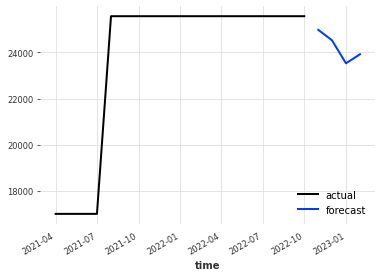

In [702]:
inverse_target_variable.plot(label ='actual')
inverse_pred_cov.plot(label ='forecast')
plt.legend()

## Experiments for full dataset - we have 20 available companies
I have multiple and multivariate time series.\
I need all the companies that have more than 20 time indexes in their rows because some series might be too short 

In [703]:
df_count = final_dataframe[['planning_group','time']].groupby("planning_group").count()
planning_groups_more_than_ten = df_count[df_count['time'] > 20].index

planning_groups_more_than_ten

Index(['company_1', 'company_11', 'company_12', 'company_13', 'company_14',
       'company_15', 'company_16', 'company_17', 'company_18', 'company_2',
       'company_3', 'company_4', 'company_6', 'company_7', 'company_8',
       'company_9'],
      dtype='string', name='planning_group')

In [704]:
pg_set = set(final_dataframe['planning_group'])


pg_unique_list = list(planning_groups_more_than_ten)
pg_unique_list

# len(pg_unique_list)
# list_pg = set(final_dataframe['planning_group'])
# list_pg

['company_1',
 'company_11',
 'company_12',
 'company_13',
 'company_14',
 'company_15',
 'company_16',
 'company_17',
 'company_18',
 'company_2',
 'company_3',
 'company_4',
 'company_6',
 'company_7',
 'company_8',
 'company_9']

I create a target series and then I split the target series on train and test sets.\
Then, I implemented a features' series and I split them on train and test sets.

In [705]:
list_pg = pg_unique_list
list_ts_feature_train = []
list_ts_feature_test = []
list_ts_target_train = []
list_ts_target_test = []

for pg in list_pg:
    actual_frequency = 'MS'
    target_series = TimeSeries.from_dataframe(df = final_dataframe[final_dataframe.planning_group == pg] ,
        time_col='time',value_cols=['euc_mrr'],freq=actual_frequency
        )
    train_target_series , test_target_series = target_series.split_before(0.8)
    list_ts_target_train.append(train_target_series)
    list_ts_target_test.append(test_target_series)

    features_series =  TimeSeries.from_dataframe(df = final_dataframe[final_dataframe.planning_group == pg],
        time_col='time',value_cols=[
        'max_boxer',
        'max_osx',
        'max_tot_enrolled',
        'max_hub',
        'max_content',
        'max_win10',
        # 'max_stickiness',
        'sr_count_score',
        'ttr_sev12_score', 
        'sev1_ratio_score',
        'esc_score',
        'pr_to_sr_ratio_score',
        'average_tech_health_score'
        ],freq=actual_frequency
        )
    train_features_series , test_features_series = features_series.split_before(0.8)
    list_ts_feature_train.append(train_features_series)
    list_ts_feature_test.append(test_features_series)


In [706]:
scaler = StandardScaler(with_mean=True)

transformer_features = Scaler(scaler,verbose=False)
transformer_features.fit(series=list_ts_feature_train+list_ts_feature_test)

transformer_target = Scaler(scaler,verbose=False)
transformer_target.fit(series=list_ts_target_train+list_ts_target_test)


Scaler

In [707]:
input_chunk = 7
output_chunk = 6
# 15 is average rows per pg
# the following formula is given in the documentation of darts
epochs_per_pg = 15 - input_chunk-output_chunk + 1 
# len of all pgs = len(pg_unique_list)
epochs = 20*epochs_per_pg
epochs

60

# First model
I use NBEATS model (https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html)

In [708]:
model = NBEATSModel(
                    input_chunk_length=input_chunk, 
                    output_chunk_length=output_chunk, # output length of 3
                    n_epochs=epochs,
                    random_state=33,
                    pl_trainer_kwargs  = {"accelerator": "cpu"}
                    )

In [709]:
target_train = [transformer_target.transform(target) for target in list_ts_target_train]
features_past_covariates = [transformer_features.transform(feature) for feature in list_ts_feature_train]

In [710]:
# target_train[0]

In [711]:
model.fit(series = target_train,
past_covariates = features_past_covariates,
verbose = False
)
# takes around 20 mins

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=60` reached.


In [712]:
pred_cov = model.predict(
    n=6,
    series = target_train,
    past_covariates = features_past_covariates
)


In [713]:
inverse_pred_cov = [transformer_target.inverse_transform(pred) for pred in pred_cov]
# inverse_pred_cov[5]

In [714]:
# pred_cov[4]

c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 194709.37% -Mean Absolute Percentage Error


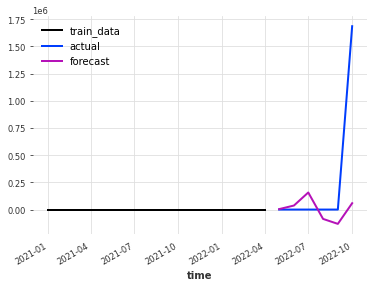

In [715]:
list_ts_target_train[4].plot(label = 'train_data')
list_ts_target_test[4].plot(label = 'actual')
inverse_pred_cov[4].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[4], inverse_pred_cov[4])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[4], inverse_pred_cov[4])))


RMSLE = 0.86 - Root Mean Squared Log Error 
MAPE = 50.93% -Mean Absolute Percentage Error


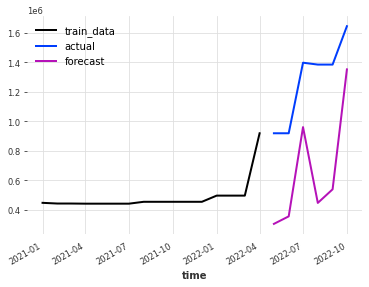

In [716]:
list_ts_target_train[3].plot(label = 'train_data')
list_ts_target_test[3].plot(label = 'actual')
inverse_pred_cov[3].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[3], inverse_pred_cov[3])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[3], inverse_pred_cov[3])))


RMSLE = 1.74 - Root Mean Squared Log Error 
MAPE = 487.12% -Mean Absolute Percentage Error


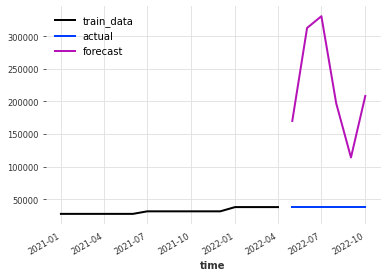

In [717]:
list_ts_target_train[2].plot(label = 'train_data')
list_ts_target_test[2].plot(label = 'actual')
inverse_pred_cov[2].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[2], inverse_pred_cov[2])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[2], inverse_pred_cov[2])))


c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 95.50% -Mean Absolute Percentage Error


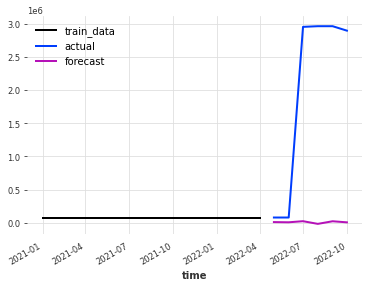

In [718]:
list_ts_target_train[5].plot(label = 'train_data')
list_ts_target_test[5].plot(label = 'actual')
inverse_pred_cov[5].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[5], inverse_pred_cov[5])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[5], inverse_pred_cov[5])))


# Second model
I use as second model Temporal Convolutional Network\
 (https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html)

In [719]:
tcn_model = TCNModel(
    input_chunk_length=input_chunk, 
    output_chunk_length=output_chunk,
    n_epochs = epochs
    )

In [720]:
target_train = [transformer_target.transform(target) for target in list_ts_target_train]
features_past_covariates = [transformer_features.transform(feature) for feature in list_ts_feature_train]

In [721]:

tcn_model.fit(series = target_train,
past_covariates = features_past_covariates,
verbose = False
)
# takes 3 mins approximately

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=60` reached.


In [722]:
pred_cov = tcn_model.predict(
    n=6,
    series = target_train,
    past_covariates = features_past_covariates
)


In [723]:
inverse_pred_cov = [transformer_target.inverse_transform(pred) for pred in pred_cov]
# inverse_pred_cov[5]

c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 6125887.97% -Mean Absolute Percentage Error


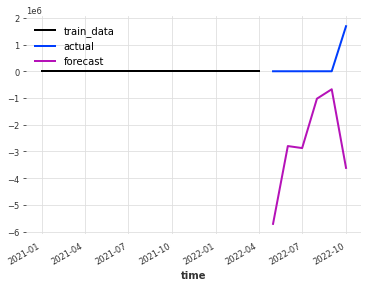

In [724]:
list_ts_target_train[4].plot(label = 'train_data')
list_ts_target_test[4].plot(label = 'actual')
# list_ts_target_train[0]
inverse_pred_cov[4].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[4], inverse_pred_cov[4])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[4], inverse_pred_cov[4])))


c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 1037.06% -Mean Absolute Percentage Error


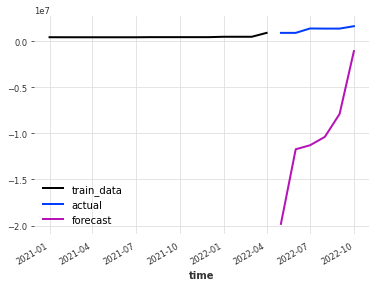

In [725]:
list_ts_target_train[3].plot(label = 'train_data')
list_ts_target_test[3].plot(label = 'actual')
inverse_pred_cov[3].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[3], inverse_pred_cov[3])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[3], inverse_pred_cov[3])))


RMSLE = 3.66 - Root Mean Squared Log Error 
MAPE = 3802.06% -Mean Absolute Percentage Error


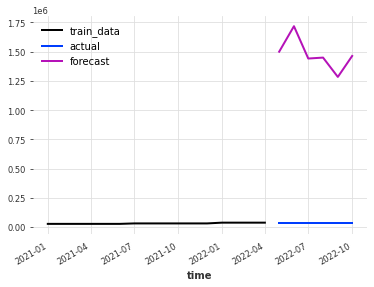

In [726]:
list_ts_target_train[2].plot(label = 'train_data')
list_ts_target_test[2].plot(label = 'actual')
inverse_pred_cov[2].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[2], inverse_pred_cov[2])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[2], inverse_pred_cov[2])))

c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 104.16% -Mean Absolute Percentage Error


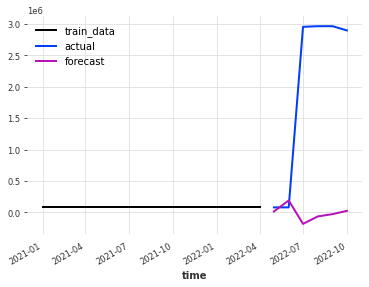

In [727]:
list_ts_target_train[5].plot(label = 'train_data')
list_ts_target_test[5].plot(label = 'actual')
inverse_pred_cov[5].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[5], inverse_pred_cov[5])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[5], inverse_pred_cov[5])))


In [728]:
list_accuracy_second = []
for element in range(0,len(planning_group_names),5):
    # print(element)
    error = round(float(rmsle(list_ts_target_test[int(element)], inverse_pred_cov[int(element)])),2)
    list_accuracy_second.append(error)
# print(list_accuracy_second)
sum_list = sum(list_accuracy_second)
count_list = len(list_accuracy_second)
result = sum_list / count_list
print(f'The average rmsle error is {result:.2f}')

The average rmsle error is 0.22


# Third model
I use as third model Temporal Fusion Transformer (TFT)\
(https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html)

In [729]:
tft_model = TFTModel(
    input_chunk_length=input_chunk, 
    output_chunk_length=output_chunk,
    n_epochs = epochs)

In [730]:
target_train = [transformer_target.transform(target) for target in list_ts_target_train]
features_past_covariates = [transformer_features.transform(feature) for feature in list_ts_feature_train]

In [731]:
tcn_model.fit(series = target_train,
past_covariates = features_past_covariates,
verbose = True
)
# takes 3.26 mins approximately

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TCNModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


In [732]:
pred_cov = tcn_model.predict(
    n=6,
    series = target_train,
    past_covariates = features_past_covariates
)


Predicting: 2it [00:00, ?it/s]

In [733]:
inverse_pred_cov = [transformer_target.inverse_transform(pred) for pred in pred_cov]
# inverse_pred_cov[5]

c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 1874858.42% -Mean Absolute Percentage Error


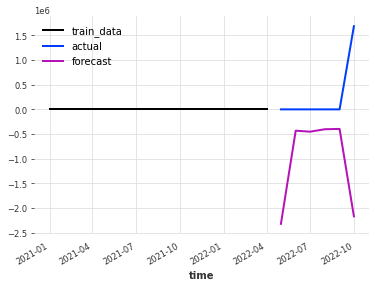

In [734]:
list_ts_target_train[4].plot(label = 'train_data')
list_ts_target_test[4].plot(label = 'actual')
inverse_pred_cov[4].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[4], inverse_pred_cov[4])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[4], inverse_pred_cov[4])))


c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 75.77% -Mean Absolute Percentage Error


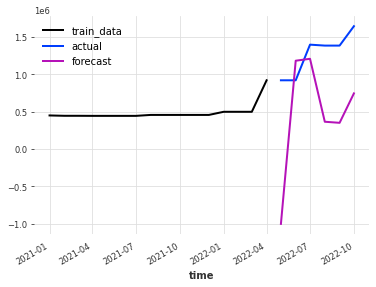

In [735]:
list_ts_target_train[3].plot(label = 'train_data')
list_ts_target_test[3].plot(label = 'actual')
inverse_pred_cov[3].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[3], inverse_pred_cov[3])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[3], inverse_pred_cov[3])))

RMSLE = 2.68 - Root Mean Squared Log Error 
MAPE = 1394.69% -Mean Absolute Percentage Error


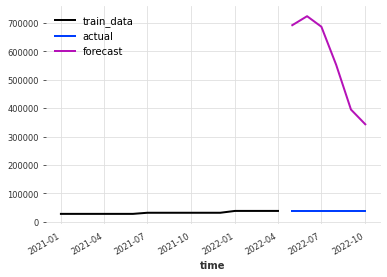

In [736]:
list_ts_target_train[2].plot(label = 'train_data')
list_ts_target_test[2].plot(label = 'actual')
inverse_pred_cov[2].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[2], inverse_pred_cov[2])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[2], inverse_pred_cov[2])))


c:\Users\as\anaconda3\envs\baseREC\lib\site-packages\darts\metrics\metrics.py:458: RuntimeWarning: invalid value encountered in log
  y1, y2 = np.log(y1 + 1), np.log(y2 + 1)


RMSLE = nan - Root Mean Squared Log Error 
MAPE = 104.62% -Mean Absolute Percentage Error


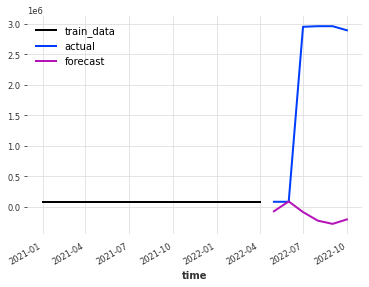

In [737]:
list_ts_target_train[5].plot(label = 'train_data')
list_ts_target_test[5].plot(label = 'actual')
inverse_pred_cov[5].plot(label= 'forecast')

print("RMSLE = {:.2f} - Root Mean Squared Log Error ".format(rmsle(list_ts_target_test[5], inverse_pred_cov[5])))
print("MAPE = {:.2f}% -Mean Absolute Percentage Error".format(mape(list_ts_target_test[5], inverse_pred_cov[5])))

In [738]:
# r2_score

list_accuracy_third = []
for element in range(0,len(planning_group_names),5):
    # print(element)
    error = round(float(mae(list_ts_target_test[int(element)], inverse_pred_cov[int(element)])),2)
    list_accuracy_third.append(error)
# print(list_accuracy_second)
sum_list_third = sum(list_accuracy_third)
len_list_third = len(list_accuracy_third)
result_third = sum_list_third / len_list_third


print(f'The average mae error is {result_third:.2f}')

The average mae error is 3858.08


# Create a model for testing purposes and Hyperparameter optimization

Load libraries

In [739]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.datasets import ElectricityDataset
from darts.models import TCNModel, LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.likelihood_models import GaussianLikelihood

In [740]:
""" Implement a function to build and fit a TCN Model, which we will re-use later.
"""


def build_fit_tcn_model(
    in_len,
    out_len,
    # kernel_size,
    num_filters,
    weight_norm,
    dilation_base,
    dropout,
    lr,
    include_dayofweek,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    BATCH_SIZE = 1024
    MAX_N_EPOCHS = 10
    NR_EPOCHS_VAL_PERIOD = 1
    MAX_SAMPLES_PER_TS = 1000

    # optionally also add the day of the week (cyclically encoded) as a past covariate
    encoders = {"cyclic": {"past": ["dayofweek"]}} if include_dayofweek else None

    # build the TCN model
    model = TCNModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=BATCH_SIZE,
        n_epochs=MAX_N_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=likelihood,
        model_name="tcn_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # train the model
    model.fit(
        series = target_train,
        past_covariates = features_past_covariates,
        max_samples_per_ts = MAX_SAMPLES_PER_TS,
    )

    return model

In [741]:
model = build_fit_tcn_model(
    in_len=input_chunk,
    out_len=output_chunk,
    num_filters=5,
    weight_norm=False,
    dilation_base=2,
    dropout=0.2,
    lr=1e-3,
    include_dayofweek=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 452   
----------------------------------------------------
452       Trainable params
0         Non-trainable params
452       Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [742]:
preds = model.predict(series=target_train, n=6, past_covariates = features_past_covariates)


Predicting: 16it [00:00, ?it/s]

In [743]:
def eval_model(preds, name, train_set=target_train, val_set=list_ts_target_test):
    smapes = smape(preds, val_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    for i in [1, 2, 3, 4, 5]:
        plt.figure(figsize=(15, 5))
        train_set[i].plot()
        val_set[i].plot(label="actual")
        preds[i].plot(label="forecast")

First TCN model sMAPE: 193.78 +- 23.54


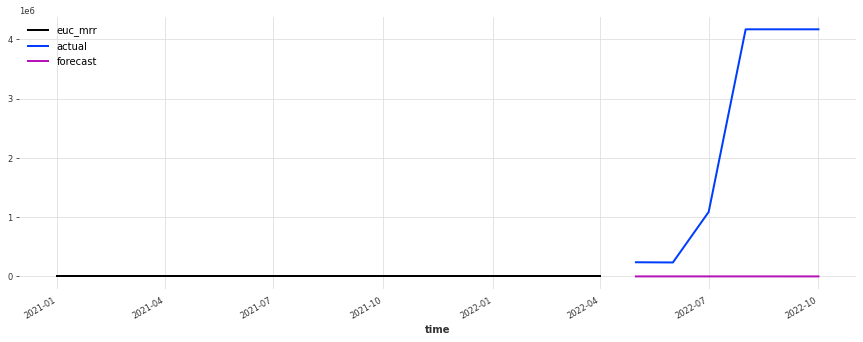

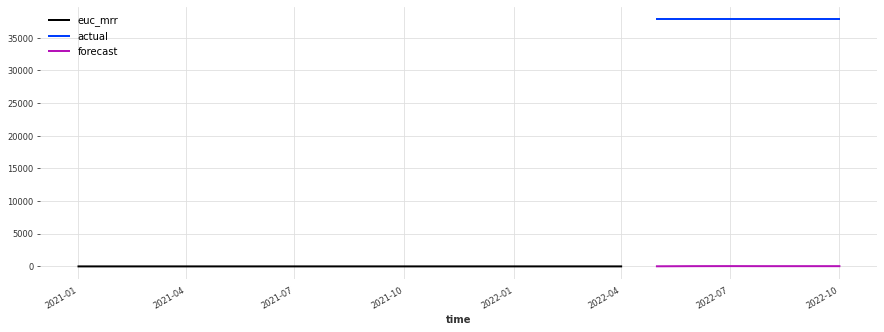

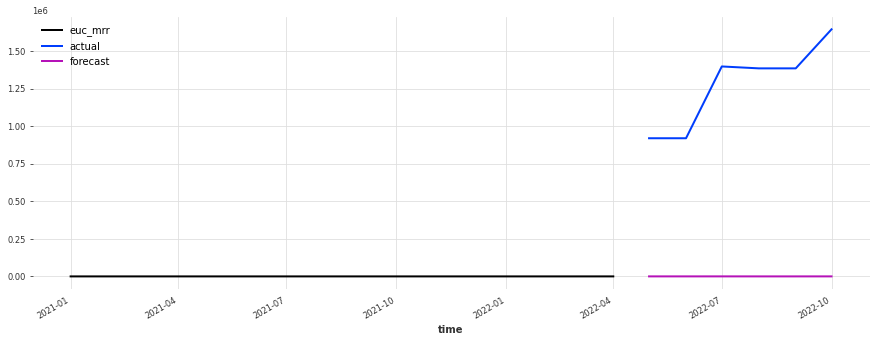

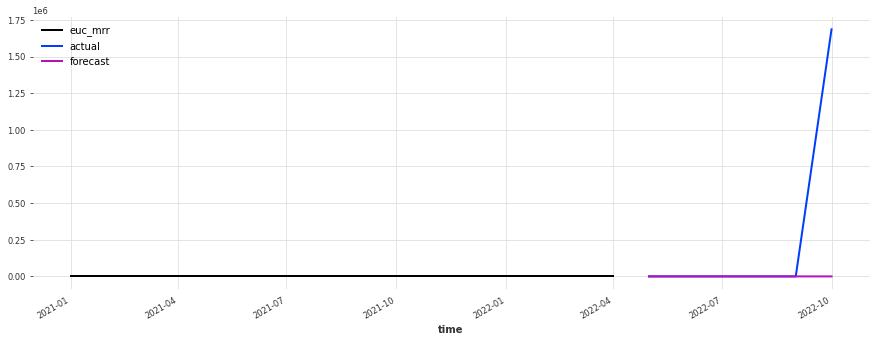

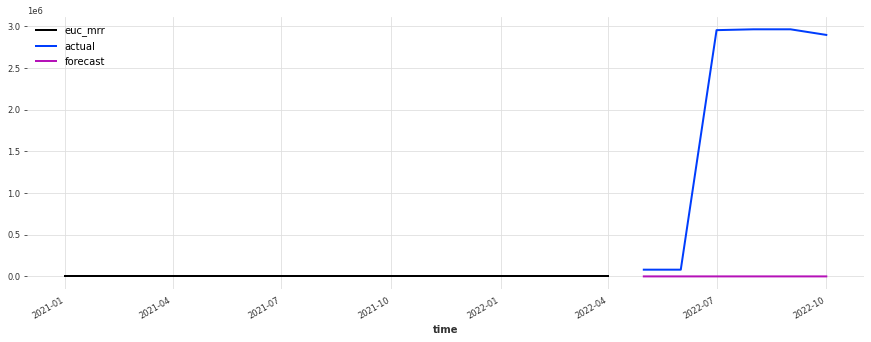

In [744]:
eval_model(preds, "First TCN model")

Hyperparameter optimization using Optuna (https://optuna.org)

In [745]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping


In [746]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 3 and 12 days
    input_chunk = trial.suggest_int("input_chunk", 7, 10)

    
    output_chunk = trial.suggest_int("output_chunk", 6, 6)

    # Other hyperparameters
    num_filters = trial.suggest_int("num_filters", 5, 25)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    include_dayofweek = trial.suggest_categorical("dayofweek", [False, True])

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tcn_model(
        in_len=input_chunk,
        out_len=output_chunk,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        lr=lr,
        include_dayofweek=include_dayofweek,
        callbacks=callback,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=target_train, n=6, past_covariates = features_past_covariates)
    smapes = smape(list_ts_target_test, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

I print the results, the best values and the best parameters

In [747]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, timeout=1200, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2022-11-25 11:12:26,820] A new study created in memory with name: no-name-b7f93550-a647-49fc-a6ae-b76f4680f88c
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 772   
----------------------------------------------------
772       Trainable params
0         Non-trainable params
772       Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:13:24,927] Trial 0 finished with value: 195.0747809997962 and parameters: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 7, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.15739973444599353, 'lr': 7.20900244177147e-05, 'dayofweek': True}. Best is trial 0 with value: 195.0747809997962.


Current value: 195.0747809997962, Current params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 7, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.15739973444599353, 'lr': 7.20900244177147e-05, 'dayofweek': True}
Best value: 195.0747809997962, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 7, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.15739973444599353, 'lr': 7.20900244177147e-05, 'dayofweek': True}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 5.1 K 
----------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:14:29,831] Trial 1 finished with value: 190.20033717362958 and parameters: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 3.1 K 
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.025     Total estimated model params size (MB)


Current value: 190.20033717362958, Current params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:15:29,168] Trial 2 finished with value: 196.00905235575465 and parameters: {'input_chunk': 10, 'output_chunk': 6, 'num_filters': 18, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.019712046901750525, 'lr': 0.0003318107424659455, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 578   
----------------------------------------------------
578       Trainable params
0         Non-trainable params
578       Total params
0.005     Total estimated model params size (MB)


Current value: 196.00905235575465, Current params: {'input_chunk': 10, 'output_chunk': 6, 'num_filters': 18, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.019712046901750525, 'lr': 0.0003318107424659455, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:16:22,964] Trial 3 finished with value: 191.50485518077653 and parameters: {'input_chunk': 10, 'output_chunk': 6, 'num_filters': 6, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.02458502011541044, 'lr': 0.00013373785180054436, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 468   
----------------------------------------------------
468       Trainable params
0         Non-trainable params
468       Total params
0.004     Total estimated model params size (MB)


Current value: 191.50485518077653, Current params: {'input_chunk': 10, 'output_chunk': 6, 'num_filters': 6, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.02458502011541044, 'lr': 0.00013373785180054436, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:17:15,716] Trial 4 finished with value: 194.65345392718132 and parameters: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 5, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.3308680793616745, 'lr': 7.052150481268392e-05, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.6 K 
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.013     Total estimated model params size (MB)


Current value: 194.65345392718132, Current params: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 5, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.3308680793616745, 'lr': 7.052150481268392e-05, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:18:16,727] Trial 5 finished with value: 197.9459137534841 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.28550517878406134, 'lr': 0.0003585478869134543, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.


Current value: 197.9459137534841, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.28550517878406134, 'lr': 0.0003585478869134543, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 5.1 K 
----------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:19:26,853] Trial 6 finished with value: 196.5030227402966 and parameters: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.1766734000313996, 'lr': 0.00023992018746507509, 'dayofweek': True}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 3.1 K 
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.025     Total estimated model params size (MB)


Current value: 196.5030227402966, Current params: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.1766734000313996, 'lr': 0.00023992018746507509, 'dayofweek': True}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:20:30,743] Trial 7 finished with value: 191.1215726723005 and parameters: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 18, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.34788884066984566, 'lr': 0.00016345956933425955, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.


Current value: 191.1215726723005, Current params: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 18, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.34788884066984566, 'lr': 0.00016345956933425955, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 2.1 K 
----------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.017     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:21:25,550] Trial 8 finished with value: 199.27381346388592 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 15, 'weight_norm': False, 'dilation_base': 2, 'dropout': 0.07172396671188608, 'lr': 0.0004428631566589165, 'dayofweek': True}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 2.5 K 
----------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.020     Total estimated model params size (MB)


Current value: 199.27381346388592, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 15, 'weight_norm': False, 'dilation_base': 2, 'dropout': 0.07172396671188608, 'lr': 0.0004428631566589165, 'dayofweek': True}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:22:23,803] Trial 9 finished with value: 199.87244334954974 and parameters: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 16, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.15193122661103967, 'lr': 8.110965958803325e-05, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.


Current value: 199.87244334954974, Current params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 16, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.15193122661103967, 'lr': 8.110965958803325e-05, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 5.1 K 
----------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:23:26,296] Trial 10 finished with value: 196.94166558070583 and parameters: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.25098799841394326, 'lr': 0.0008686168208937277, 'dayofweek': True}. Best is trial 1 with value: 190.20033717362958.


Current value: 196.94166558070583, Current params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.25098799841394326, 'lr': 0.0008686168208937277, 'dayofweek': True}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 3.8 K 
----------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:24:25,267] Trial 11 finished with value: 193.8365563320503 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 20, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.10919360239871961, 'lr': 0.00014026105876849452, 'dayofweek': True}. Best is trial 1 with value: 190.20033717362958.


Current value: 193.8365563320503, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 20, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.10919360239871961, 'lr': 0.00014026105876849452, 'dayofweek': True}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 4.1 K 
----------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.033     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:25:24,358] Trial 12 finished with value: 194.17160079682012 and parameters: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 21, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.3780386548065656, 'lr': 0.0001414394774949481, 'dayofweek': True}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 5.3 K 
----------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.043     Total estimated model params size (MB)


Current value: 194.17160079682012, Current params: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 21, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.3780386548065656, 'lr': 0.0001414394774949481, 'dayofweek': True}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:26:28,397] Trial 13 finished with value: 199.72208122224728 and parameters: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 25, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.2322491963620532, 'lr': 0.00010901759498407582, 'dayofweek': False}. Best is trial 1 with value: 190.20033717362958.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.6 K 
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.013     Total estimated model params size (MB)


Current value: 199.72208122224728, Current params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 25, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.2322491963620532, 'lr': 0.00010901759498407582, 'dayofweek': False}
Best value: 190.20033717362958, Best params: {'input_chunk': 9, 'output_chunk': 6, 'num_filters': 24, 'weight_norm': False, 'dilation_base': 4, 'dropout': 0.12538565855886175, 'lr': 0.00010782501466044544, 'dayofweek': True}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:27:24,529] Trial 14 finished with value: 189.13854353250338 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}. Best is trial 14 with value: 189.13854353250338.


Current value: 189.13854353250338, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.5 K 
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:28:15,482] Trial 15 finished with value: 189.62115583456705 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 11, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.08041616859943984, 'lr': 5.24557420982739e-05, 'dayofweek': True}. Best is trial 14 with value: 189.13854353250338.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.2 K 
----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.010     Total estimated model params size (MB)


Current value: 189.62115583456705, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 11, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.08041616859943984, 'lr': 5.24557420982739e-05, 'dayofweek': True}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:29:04,777] Trial 16 finished with value: 190.40953719329966 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 10, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.39967512585304166, 'lr': 0.0006990494923769006, 'dayofweek': False}. Best is trial 14 with value: 189.13854353250338.


Current value: 190.40953719329966, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 10, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.39967512585304166, 'lr': 0.0006990494923769006, 'dayofweek': False}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.5 K 
----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:29:56,452] Trial 17 finished with value: 194.98305127518717 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 11, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.07245707018584396, 'lr': 5.0632344273363783e-05, 'dayofweek': True}. Best is trial 14 with value: 189.13854353250338.


Current value: 194.98305127518717, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 11, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.07245707018584396, 'lr': 5.0632344273363783e-05, 'dayofweek': True}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.1 K 
----------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:30:44,844] Trial 18 finished with value: 193.92971674486148 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 9, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.20773407622644213, 'lr': 0.0005485855000554851, 'dayofweek': True}. Best is trial 14 with value: 189.13854353250338.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.6 K 
----------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.013     Total estimated model params size (MB)


Current value: 193.92971674486148, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 9, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.20773407622644213, 'lr': 0.0005485855000554851, 'dayofweek': True}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:31:36,028] Trial 19 finished with value: 198.3894322735495 and parameters: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 13, 'weight_norm': False, 'dilation_base': 2, 'dropout': 0.29333069910935783, 'lr': 0.00023642605812479258, 'dayofweek': False}. Best is trial 14 with value: 189.13854353250338.


Current value: 198.3894322735495, Current params: {'input_chunk': 7, 'output_chunk': 6, 'num_filters': 13, 'weight_norm': False, 'dilation_base': 2, 'dropout': 0.29333069910935783, 'lr': 0.00023642605812479258, 'dayofweek': False}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 930   
----------------------------------------------------
930       Trainable params
0         Non-trainable params
930       Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Predicting: 16it [00:00, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2022-11-25 11:32:33,189] Trial 20 finished with value: 193.7733216323061 and parameters: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 8, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.06259920936830986, 'lr': 0.0001871078819711459, 'dayofweek': True}. Best is trial 14 with value: 189.13854353250338.


Current value: 193.7733216323061, Current params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 8, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.06259920936830986, 'lr': 0.0001871078819711459, 'dayofweek': True}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}
Best value: 189.13854353250338, Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}


Best value: 189.13854353250338\
 Best params: {'input_chunk': 8, 'output_chunk': 6, 'num_filters': 12, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.36042557554393706, 'lr': 0.00020635508665355553, 'dayofweek': False}

Now we can train a model with these parameters and we will have the best result and the most optimized performance metrics.
